# PHXS 491_001: Observational Astronomy - Homework 5

### Due Oct 19, 2021
Remember to save your completed notebook as a PDF and upload to Brightspace under Assignments.

Name:

## Please use the "primt()" function (notice the "m") to print out your answers in magenta.  This makes grading easier.  You might need to "print to PDF" to get the colors to show up.

In [1]:
def primt(*args):
    '''
    For any amount of arguments "*args", prints in magenta.
    '''
    magenta = "\x1B[38;5;201m"   # the color in ANSI code
    for el in args:  # for each argument
        magenta += " "+(str(el))  # add the argument to the string to be printed
    print(magenta)   #print!

# Overscan, Trim, and Bias

In [2]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import os
from glob import glob
import matplotlib
import astropy.stats
# matplotlib.use('nbagg')

In [3]:
# A little script to get information on all the fits files
def ccdlist(input=None):
    if input is None: input='*.fits'
    files = glob(input)
    nfiles = len(files)
    dt = np.dtype([('file',np.str,100),('naxis1',int),('naxis2',int),
                      ('imagetyp',np.str,100),('exptime',float),('filter',np.str,100)])
    cat = np.zeros(nfiles,dtype=dt)
    for i,f in enumerate(files):
        base = os.path.basename(f)
        base = base.split('.')[0]
        h = fits.getheader(f)
        cat['file'][i] = f
        cat['naxis1'][i] = h.get('naxis1')
        cat['naxis2'][i] = h.get('naxis2')
        cat['imagetyp'][i] = h.get('imagetyp')
        cat['exptime'][i] = h.get('exptime')
        cat['filter'][i] = h.get('filter')
        print (base+'  '+str(cat['naxis1'][i])+'  '+str(cat['naxis2'][i])+'  '+cat['imagetyp'][i]+'  '+str(cat['exptime'][i])+'  '+cat['filter'][i])
    return cat

### Unzip the ``calibration_data.zip`` file and load the information using the ``ccdlist`` function.

In [4]:
out=ccdlist('data/calibration_data/*.fit')

Bias-0001  3468  2728  Bias Frame  0.001000000047497  None
Bias-0002  3468  2728  Bias Frame  0.001000000047497  None
Bias-0003  3468  2728  Bias Frame  0.001000000047497  None
Bias-0004  3468  2728  Bias Frame  0.001000000047497  None
Bias-0005  3468  2728  Bias Frame  0.001000000047497  None
Bias-0006  3468  2728  Bias Frame  0.001000000047497  None
Bias-0007  3468  2728  Bias Frame  0.001000000047497  None
Bias-0008  3468  2728  Bias Frame  0.001000000047497  None
Bias-0009  3468  2728  Bias Frame  0.001000000047497  None
Bias-0010  3468  2728  Bias Frame  0.001000000047497  None
DoubleCluster-0003B  3468  2728  Light Frame  120.0  Blue
DoubleCluster-0003R  3468  2728  Light Frame  120.0  Red
DoubleCluster-0023B  3468  2728  Light Frame  30.0  Green
master_dark  3388  2712  Dark Frame  60.0  None
master_flat  3388  2712  Light Frame  30.0  None


## 1. Overscan

Load the data and header (using fits.getdata) for one of the DoubleCluster images.  Plot up the image.

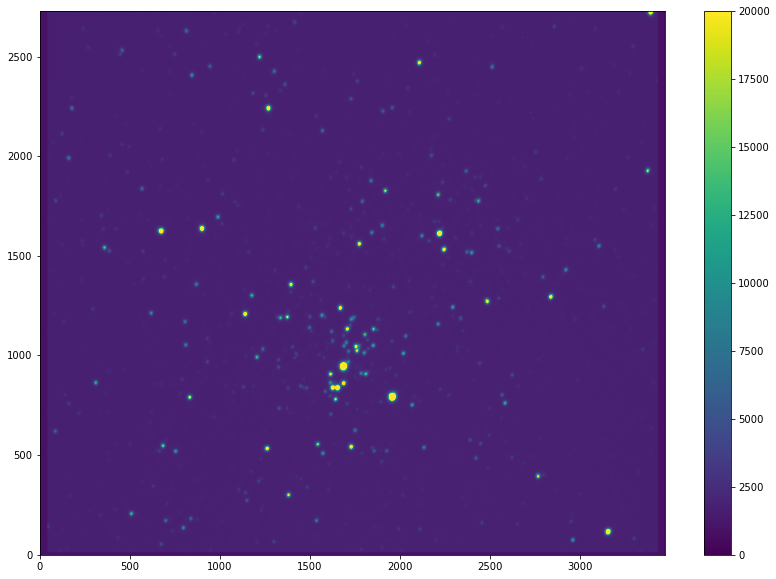

In [5]:
im, head = fits.getdata('data/calibration_data/DoubleCluster-0003R.fit',0,header=True)
plt.figure(figsize=(14,10))
plt.imshow(im,aspect='auto',vmax=20000,origin='lower')
plt.colorbar()
plt.show()

Figure out where the overscan regions are on the left and the right-hand side.

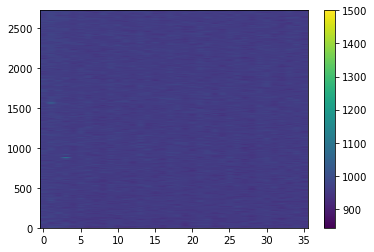

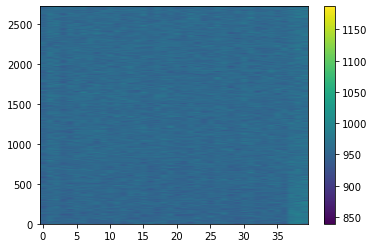

In [42]:
over_right = im[:,3429:-3]    # right
over_left = im[:,0:40]        # left
over_bot = im[0:14,:-3]       # bottom

plt.imshow(over_right,aspect='auto', vmax=1500,origin='lower')
plt.colorbar()
plt.show()

plt.imshow(over_left,aspect='auto',origin='lower')
plt.colorbar()
plt.show()

Calculate the median overscan value using the largest overscan regions.

In [43]:
over = np.append(over_right.flatten(), over_left.flatten())
over = np.append(over.flatten(), over_bot.flatten())
over_med = np.median(over)
over_sig_mean = astropy.stats.sigma_clipped_stats(over)[0]
over_med

960.0

Figure out where the data section is.

In [44]:
im_data = im[14:-3,41:3429]

Subtract the overscan value from the data section.

In [45]:
im_data = im_data - over_sig_mean

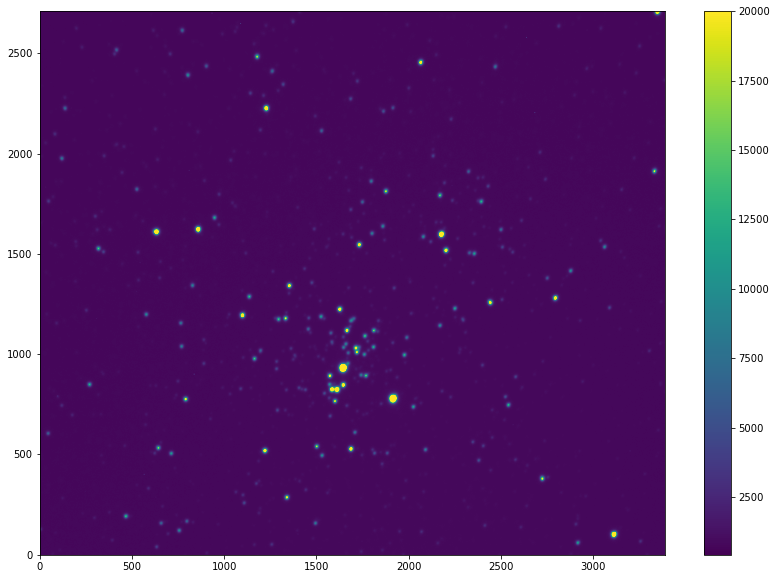

In [46]:
plt.figure(figsize=(14,10))
plt.imshow(im_data,aspect='auto',vmax=20000,origin='lower')
plt.colorbar()
plt.show()

Write a small function called ``overscan()`` that performs all of these tasks given the image and header.

In [60]:
def overscan_const(im1):
    over_right = im1[:,3429:-3]    # right
    over_left = im1[:,0:40]
    over_bot = im1[0:14,:-3]
    im1_data = im1[14:-3,41:3429]
    
    over = np.append(over_right.flatten(), over_left.flatten())
    over = np.append(over.flatten(), over_bot.flatten())
#     over_sig_mean = np.median(over)
    over_sig_mean = astropy.stats.sigma_clipped_stats(over)[0]
    return im1_data - over_sig_mean

def overscan_lin(im1):
    over_right = im1[:,3429:-3]    # right
    over_left = im1[:,0:40]
    over_bot = im1[0:14,:-3]
    
    im1_data = im1[14:-3,41:3429]
    
    con = np.concatenate([over_right, over_left],axis=1)
    means = astropy.stats.sigma_clipped_stats(con[:len(im1_data)], axis=1)[0]
    p = np.polyfit(np.arange(len(means)), means, 1)
    sub = np.arange(len(means))*p[0] - p[1]
    sub = np.repeat(sub,im1_data.shape[1])
    sub = sub.reshape(im1_data.shape)
    im1_data_new = im1_data+sub
    return im1_data_new

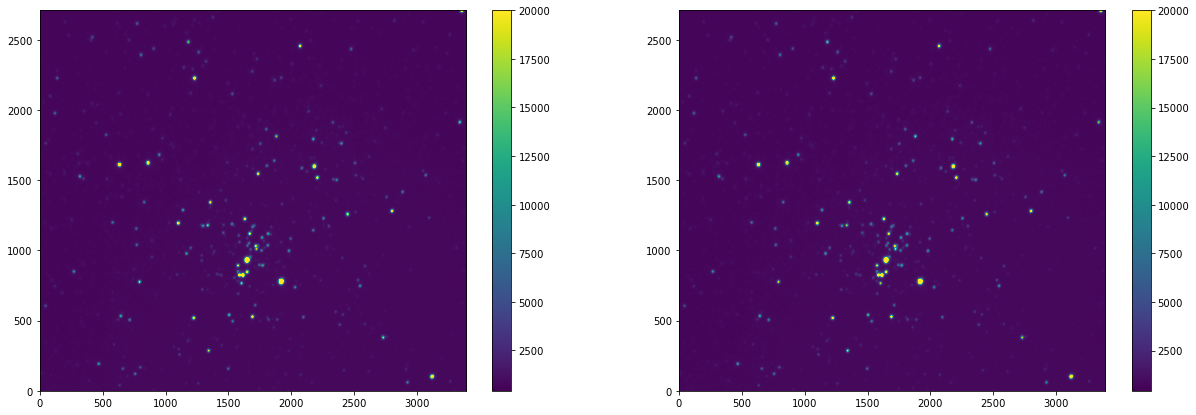

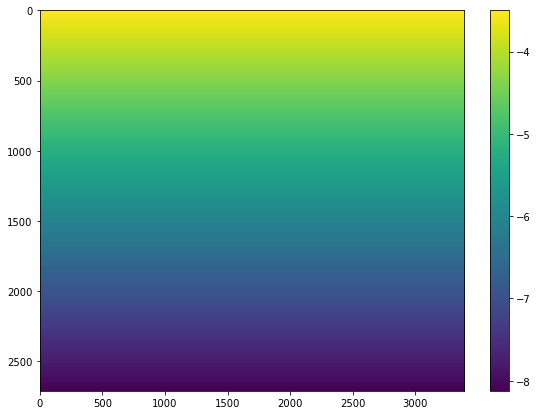

In [61]:
im, head = fits.getdata('data/calibration_data/DoubleCluster-0003R.fit',0,header=True)

plt.figure(figsize = (21,7))
plt.subplot(121)
plt.imshow(overscan_const(im),aspect='auto',vmax=20000,origin='lower')
plt.colorbar()


plt.subplot(122)
plt.imshow(overscan_lin(im),aspect='auto',vmax=20000,origin='lower')
plt.colorbar()
plt.show()

plt.figure(figsize=(9.5,7))
plt.imshow(overscan_const(im)-overscan_lin(im),aspect='auto')
plt.colorbar()
plt.show()

In [62]:
np.min(overscan_lin(im))

430.6828922392094

In [63]:
over_right = im[:,3429:-3]    # right
over_left = im[:,0:40]
over_bot = im[0:14,:-3]
im1_data = im[20:-3,42:3428]

over = np.append(over_right.flatten(), over_left.flatten())
over = np.append(over.flatten(), over_bot.flatten())
print(astropy.stats.sigma_clipped_stats(over)[0])
print(np.median(over))
print(np.min(im1_data))
im.shape

959.8339851334654
960.0
1384


(2728, 3468)

## 2. Trim

Figure out which section of the image you should remove and which you should keep.

Trim the image.  Verify by showing the image that it looks like what you expected.

Create a new function called ``overscantrim()`` to overscan correct and trim the image.

In [64]:
# already incorporated into overscan
def overscantrim_lin(im1):
    over_right = im1[:,3429:-3]    # right
    over_left = im1[:,0:40]
    over_bot = im1[0:14,:-3]
    
    im1_data = im1[14:-3,41:3429]
    
    con = np.concatenate([over_right, over_left],axis=1)
    means = astropy.stats.sigma_clipped_stats(con[:len(im1_data)], axis=1)[0]
    p = np.polyfit(np.arange(len(means)), means, 1)
    sub = np.arange(len(means))*p[0] - p[1]
    sub = np.repeat(sub,im1_data.shape[1])
    sub = sub.reshape(im1_data.shape)
    im1_data_new = im1_data+sub
    return im1_data_new

def overscantrim_const(im1):
    over_right = im1[:,3429:-3]    # right
    over_left = im1[:,0:40]
    over_bot = im1[0:14,:-3]
    im1_data = im1[14:-3,41:3429]
    
    over = np.append(over_right.flatten(), over_left.flatten())
    over = np.append(over.flatten(), over_bot.flatten())
#     over_sig_mean = np.median(over)
    over_sig_mean = astropy.stats.sigma_clipped_stats(over)[0]
    return im1_data - over_sig_mean

## 3. Bias

Use the ccdlist() function to get information about all of the exposures.  Use ``np.where()`` to get the names of just the bias exposures using header information in the output catalog.

In [65]:
out
head

SIMPLE  =                    T                                                  
BITPIX  =                   16 /8 unsigned int, 16 & 32 int, -32 & -64 real     
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                 3468 /fastest changing axis                           
NAXIS2  =                 2728 /next to fastest changing axis                   
BSCALE  =   1.0000000000000000 /physical = BZERO + BSCALE*array_value           
BZERO   =   32768.000000000000 /physical = BZERO + BSCALE*array_value           
DATE-OBS= '2020-02-22T04:16:44' /YYYY-MM-DDThh:mm:ss observation start, UT      
EXPTIME =   120.00000000000000 /Exposure time in seconds                        
EXPOSURE=   120.00000000000000 /Exposure time in seconds                        
SET-TEMP=  -20.000000000000000 /CCD temperature setpoint in C                   
CCD-TEMP=  -20.100000381469727 /CCD temperature at start of exposure in C       
XPIXSZ  =   3.68999999999999

In [66]:
biases = np.where("Bias Frame" == out['imagetyp'])
bias_list = out[biases][' file']

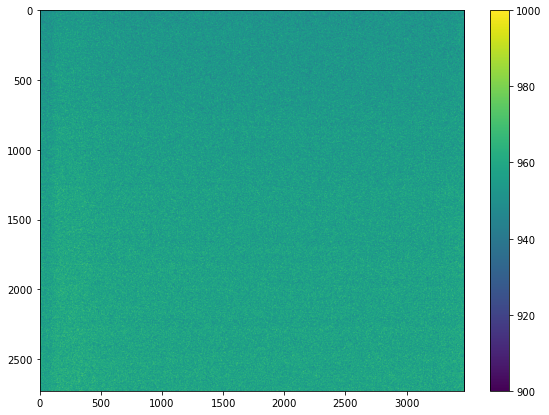

In [81]:
plt.figure(figsize=(9.5,7))
bias_im = fits.getdata(bias_list[0].replace("\\", "/"),0,header=True)[0]
plt.imshow(bias_im,aspect='auto', vmin=900, vmax=1000)
plt.colorbar()
plt.show()

Estimate the readnoise by calculating the standard deviation with ``np.std()`` on the bias images. Convert to electrons.  Is this what you expected?

In [67]:
# im, head = fits.getdata('data/calibration_data/',0,header=True)
std_list = []
for file in bias_list:
    im, head = fits.getdata(file.replace("\\", "/"),0,header=True)
    std_list.append(np.std(im))
std_list = np.array(std_list)
std_list * head['EGAIN']

array([6.00384342, 5.99860973, 6.00498496, 6.00325417, 6.00661661,
       6.00672225, 6.00821842, 6.00864786, 6.00366583, 6.00669046])

Initialize a 3D array using ``np.zeros()`` or ``np.empty()`` of size [Ny,Nx,Nframes] that will contain all of the bias images.  Loop over the bias exposures, run your ``overscantrim()`` function on it, and then plug the image into your 3D array.

In [82]:
trimmed_bias = np.zeros([len(bias_list), head['NAXIS2']-17, head['NAXIS1']-80])
for i in range(len(bias_list)):
    bias_im = fits.getdata(file.replace("\\", "/"),0,header=True)[0]
    trimmed_bias[i] = overscantrim_lin(bias_im)

In [83]:
np.min(trimmed_bias[0])

-131.92986167007302

Use np.mean() with the `axis` keyword to average all of the bias exposures.  Does the average look less noisy than the individual bias images?

In [72]:
mean_trimmed_bias = np.mean(trimmed_bias, axis=0)
print(mean_trimmed_bias)

[[ 6.96434593e+00  3.96434593e+00 -2.03565407e+00 ... -2.90356541e+01
  -4.10356541e+01 -6.03565407e+00]
 [ 8.96434593e+00  2.09643459e+01 -4.80356541e+01 ...  2.09643459e+01
   4.89643459e+01  2.49643459e+01]
 [ 5.29643459e+01 -4.00356541e+01 -3.56540697e-02 ... -2.70356541e+01
   5.96434593e+00  1.96434593e+00]
 ...
 [-2.40356541e+01 -1.00356541e+01 -1.70356541e+01 ...  3.19643459e+01
  -2.70356541e+01  1.96434593e+00]
 [ 1.49643459e+01  9.64345930e-01  4.09643459e+01 ... -4.90356541e+01
  -3.40356541e+01  2.49643459e+01]
 [ 2.99643459e+01  8.96434593e+00 -9.03565407e+00 ... -4.20356541e+01
   2.19643459e+01  2.29643459e+01]]


What is the scatter/noise in the image compared to a single bias image that you calculated above?  Is the reduction what you expected?  How many biases would you need to average to reduce the noise to 1 ADU?

In [85]:
# SN_bias = np.sqrt(mean_trimmed_bias / head['EGAIN'])
# SN_bias
np.std(mean_trimmed_bias*head['EGAIN'])

4.053154740334642

Create a function called ``masterbias()`` that performs these steps and creates a ``master bias`` image.

In [86]:
def masterbias():
    biases = np.where("Bias Frame" == out['imagetyp'])
    bias_list = out[biases]['file']

    trimmed_bias = np.zeros([len(bias_list), head['NAXIS2']-17, head['NAXIS1']-80])
    for i in range(len(bias_list)):
        bias_im = fits.getdata(file.replace("\\", "/"),0,header=True)[0]
        trimmed_bias[i] = overscantrim_lin(bias_im)

    return np.mean(trimmed_bias, axis=0)

Run ``masterbias()`` on all the biases to create the ``master bias`` image.

In [87]:
master_bias = masterbias()

Create a function that performs overscan, trimming and zero correction called ``overscantrimzero()``.  In addition to overscan and trimming an image, it will also use the `master bias` image to perform the bias correction.

In [104]:
# already incorporated into overscan
def overscantrim_lin(im1):
    over_right = im1[:,3429:-3]    # right
    over_left = im1[:,0:40]
    over_bot = im1[0:14,:-3]
    
    im1_data = im1[14:-3,41:3429]
    
    con = np.concatenate([over_right, over_left],axis=1)
    means = astropy.stats.sigma_clipped_stats(con[:len(im1_data)], axis=1)[0]
    p = np.polyfit(np.arange(len(means)), means, 1)
    sub = np.arange(len(means))*p[0] - p[1]
    sub = np.repeat(sub,im1_data.shape[1])
    sub = sub.reshape(im1_data.shape)
    im1_data_new = im1_data+sub
    return im1_data_new

def masterbias():
    biases = np.where("Bias Frame" == out['imagetyp'])
    bias_list = out[biases]['file']

    trimmed_bias = np.zeros([len(bias_list), head['NAXIS2']-17, head['NAXIS1']-80])
    for i in range(len(bias_list)):
        bias_im = fits.getdata(file.replace("\\", "/"),0,header=True)[0]
        trimmed_bias[i] = overscantrim_lin(bias_im)

    return np.mean(trimmed_bias, axis=0)


def overscantrimzero(file_name):
#     out=ccdlist('data/calibration_data/*.fit')
    im1, head = fits.getdata('data/calibration_data/' + file_name,0,header=True)
    im1 = overscantrim_lin(im1)
    im1 -= masterbias()
    return im1

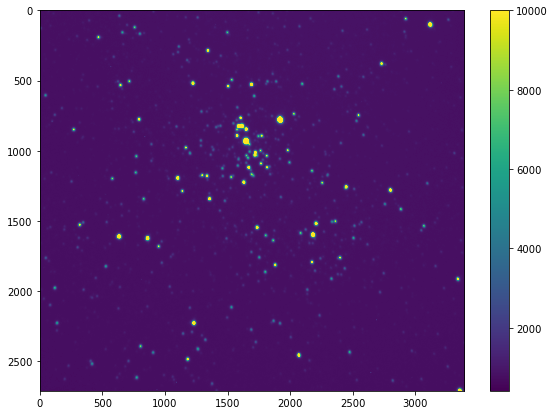

In [103]:
plt.figure(figsize=(9.5,7))
im = overscantrimzero('DoubleCluster-0003R.fit')
plt.imshow(im, aspect='auto', vmax=10000)
plt.colorbar()
plt.show()